# Chignolin clustering based on MFPT
This is a modification of the notebook given Chris (christoph.wehmeyer@fu-berlin.de), in this case we are going to use is to cluster the microstates based on the commute times.

In [1]:
import sys
import math
sys.path.append("/home/Ernesto/Dropbox/workspace/NMpathAnalysis")
sys.path.append("/home/Ernesto/Dropbox/workspace/NMpathAnalysis/nmpath")
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

# My modules
from nmpath.auxfunctions import *
from nmpath.mfpt import*
from nmpath.clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel


# Print 
from IPython.display import Markdown, display

You are still using msmtools from the deprecated Omnia channel. Please switch to conda-forge to catch future updates.
In order to do so please set conda-forge channel to highest priority by:

    conda config --add channels conda-forge

and update this package by:

    conda update msmtools




## Auxiliary functions


In [2]:
def get_lagtime_from_array(lags, lagtime, dt=0.2):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()


def plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs):
    max_ = len(t_cut_values)
    select_to_plot= range(0, max_ ,3) # This will print the first column of the free energy plots


    for i in select_to_plot:
        macrostates = big_clusters_list[i]
        rmsd_cluster0=[]
        rmsd_cluster1=[]

        for j, microstate in enumerate(dtrajs[0]):  # There is only one traj
            if microstate in macrostates[0]:
                rmsd_cluster0.append(rmsd[j])
            elif (len(macrostates) > 1) and microstate in macrostates[1]:
                rmsd_cluster1.append(rmsd[j])

        fig = plt.figure(figsize=(5,2))

        plt.hist(rmsd_cluster0,normed=True, bins=25, color="r", 
                 alpha=0.5,label="cluster-0", edgecolor="r")
        if len(macrostates) > 1:
            plt.hist(rmsd_cluster1,normed=True, bins=25, color="b", 
                     alpha=0.5,label="cluster-1", edgecolor="b")

        plt.xlabel("RMSD$(\AA)$",fontsize=12)
        plt.ylabel("Probability Dens.",fontsize=12)
        plt.legend()
        #plt.title("t_cut: {:.2f}ns".format(t_cut_values_ns[i]))
        plt.annotate("t_cut: {:.2f}ns".format(t_cut_values[i]*dt), xy=(1,2))
        plt.xlim([0,7])
        plt.show()

## Create a feature reader

We create a feature reader to obtain minimal distances between all residues which are not close neighbours. Feel free to map these distances to binary contacts or use inverse minimal residue distances instead. These coices usually work quite well.

In [3]:
traj_files = [f for f in sorted(glob('../../PathAnalysisShawProteins/CLN025-0-protein/CLN025-0-protein-*.dcd'))]
pdb_file = '../../PathAnalysisShawProteins/CLN025-0-protein/chig_pdb_166.pdb'

features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)

09-07-17 13:40:08 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


## RMSD

In [4]:
# reference = md.load_dcd("../../PathAnalysisShawProteins/CLN025-0-protein/CLN025-0-protein-000.dcd", top=pdb_file)

# CA_atoms = reference.topology.select('name CA and resid 1 to 8')

# rmsd = []

# for traj_name in traj_files:
#     traj = md.load_dcd(traj_name, top=pdb_file)
#     for element in md.rmsd(traj,reference,2000, atom_indices=CA_atoms):
#         rmsd.append(element)

# fig =plt.figure(figsize = (17,2))
# plt.plot(rmsd[::200])
# plt.axis([0,2600, 0.0, 0.7])
# plt.ylabel("RMSD(nm)")
# plt.xlabel("Snapshot Num./200")
# plt.show()

# fig =plt.figure(figsize = (10,3))

# ax1 = fig.add_subplot(121)
# ax1.hist(rmsd[::100],normed=True, bins=30, color="r", 
#          alpha=0.5, edgecolor="r")
# ax1.set_xlabel("RMSD$(\AA)$",fontsize=12)
# ax1.set_ylabel("Probability Dens.",fontsize=12)


# ax2 = fig.add_subplot(122)
# ax2.hist(rmsd[::100],normed=True, bins=30, color="r", 
#          alpha=0.5, edgecolor="r")
# ax2.set_xlabel("RMSD$(\AA)$",fontsize=12)
# ax2.set_yscale("log")
# ax2.annotate("Log scale",xy=(0.3,30))
# plt.show()

# rmsd = np.array(rmsd)*10.0  # to Angstrom

## Discretization and MSM estimation

We start the actual analysis with a TICA projection onto two components on which we perform a k-means clustering. Then, we take a quick view on the implied timescale convergence, the 2D representation, and the clustering:

09-07-17 13:42:15 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Cluster centers converged after 77 steps.


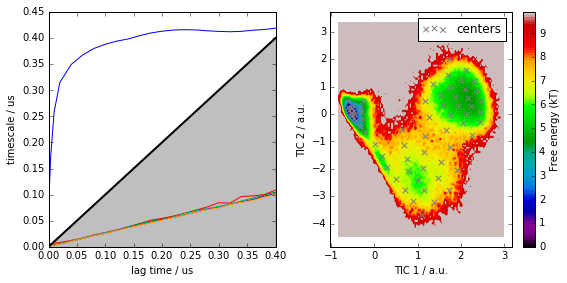

In [5]:
tica = pyemma.coordinates.tica(data=source, lag=5, dim=2).get_output()[0]
cluster = pyemma.coordinates.cluster_kmeans(tica, k=64, max_iter=100)
#print(cluster.dtrajs)

lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica.T, ax=axes[1])
axes[1].scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

# MSM estimation
msm = [pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us') for lag in lags]

## Agglomerative Clustering from the transition matrix

Hierarchical agglomerative clustering using the Markovian commute time: $t_{ij} = \mathrm{MFPT}(i \rightarrow j)+ \mathrm{MFPT}(j \rightarrow i)$.

We follow some rules to build (in every mergin step) a new set of transition probabilities $\{k_{i,j}\}$, defined with the same lag-time $\tau$. After merging two states $l$ and $m$, the probability of the transitions entering the new state that we will call "$lm$", from any state $i$, is computed as


$$k_{i,ml}=k_{i,m}+k_{i,l}$$


On the other hand the transition probabilities from $ml$ to any other state $j$ is computed as 


$$k_{ml,j}=\frac{p_m k_{m,j}+p_l k_{l,j}}{p_m+p_l}$$


Similarly,

$$k_{ml,ml}=\frac{p_m (k_{m,m}+k_{m,l})+p_l (k_{l,l}+k_{l,m})}{p_m+p_l}$$


### Lag times to use

In [6]:
#lag_to_use = [1, 10, 100, 1000]
lag_to_use = [1]

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]

# This are the t_cut intervals to explore (in lag-time units) with the lag times in "lag_to_use"
range_per_lag = [[200,700], [200,350], [100,250], [30,200]]


### Clustering

### Lag-time: 0.2ns

#### t_values:

t_cut: 40.00ns, t_min: 40.02ns, t_max: 3.96e+02ns, tAB: 179.19ns
t_cut: 46.60ns, t_min: 50.27ns, t_max: 3.93e+02ns, tAB: 172.20ns
t_cut: 53.20ns, t_min: 65.70ns, t_max: 3.92e+02ns, tAB: 172.20ns
t_cut: 59.80ns, t_min: 65.70ns, t_max: 3.92e+02ns, tAB: 172.20ns
t_cut: 66.40ns, t_min: 73.60ns, t_max: 3.92e+02ns, tAB: 172.20ns
t_cut: 73.00ns, t_min: 73.60ns, t_max: 3.92e+02ns, tAB: 172.20ns
t_cut: 79.60ns, t_min: 86.31ns, t_max: 3.88e+02ns, tAB: 172.20ns
t_cut: 86.20ns, t_min: 86.31ns, t_max: 3.88e+02ns, tAB: 172.20ns
t_cut: 92.80ns, t_min: 94.15ns, t_max: 3.57e+02ns, tAB: 219.46ns
t_cut: 99.40ns, t_min: 101.90ns, t_max: 3.45e+02ns, tAB: 223.06ns
t_cut: 106.00ns, t_min: 114.28ns, t_max: 3.44e+02ns, tAB: 0.00ns
t_cut: 112.60ns, t_min: 114.28ns, t_max: 3.44e+02ns, tAB: 0.00ns
t_cut: 119.20ns, t_min: 126.57ns, t_max: 3.44e+02ns, tAB: 0.00ns
t_cut: 125.80ns, t_min: 126.57ns, t_max: 3.44e+02ns, tAB: 0.00ns
t_cut: 132.40ns, t_min: 136.23ns, t_max: 3.44e+02ns, tAB: 0.00ns


#### Observed clusters vs t_cut

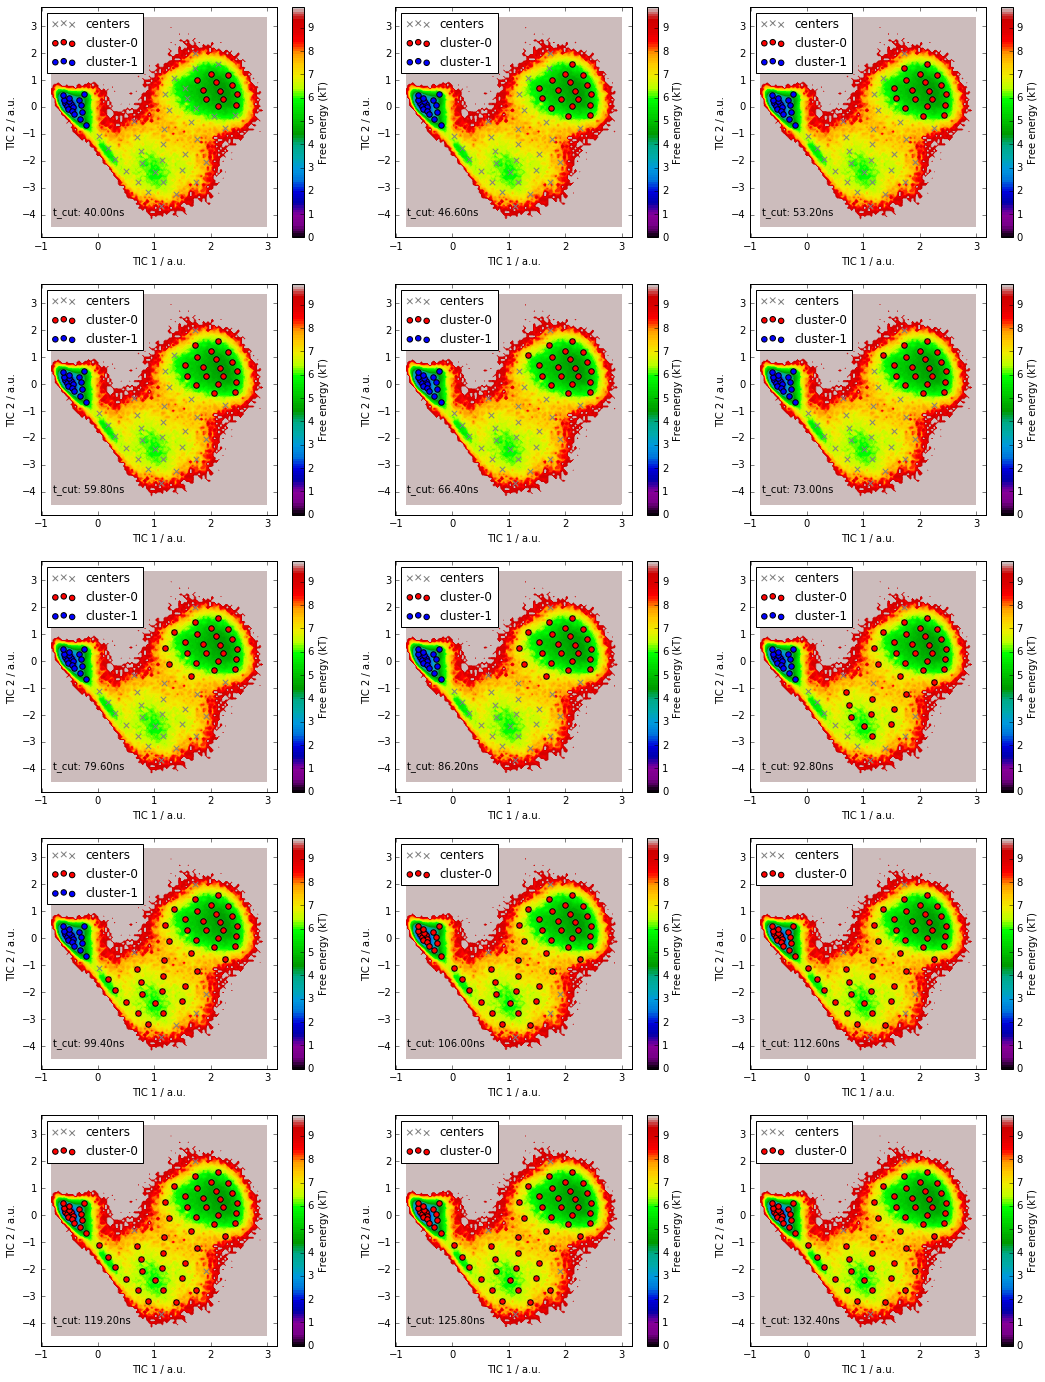

#### t_AB plots:

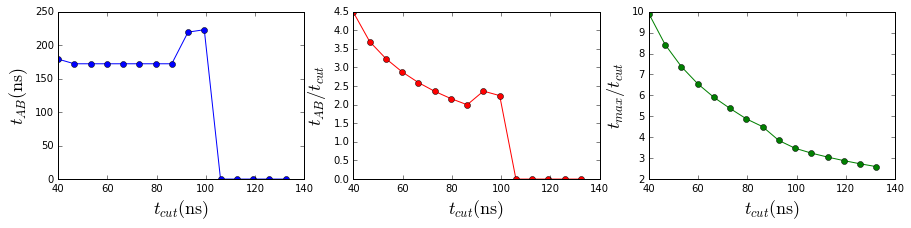

In [7]:
for k, index in enumerate(lag_index):
    K = msm[index].P
    dt = 0.2*lags[index]
    #---------------------
    printmd("### Lag-time: "+str(dt)+"ns")

    t_min_list=[]
    t_max_list=[]
    t_AB_list=[]

    big_clusters_list = []

    # t_cut range
    min_ = range_per_lag[k][0]
    max_ = range_per_lag[k][1]
    interval = (max_ - min_)//15 
    t_cut_values =  [min_+i for i in range(0,max_- min_,interval)][0:15]


    fig_n_cols = 3
    fig_n_rows = int(math.ceil(len(t_cut_values)/fig_n_cols))


    fig = plt.figure(figsize=(6*fig_n_cols, 4.8*fig_n_rows))

    printmd("#### t_values:")
    for ii, t_cut in enumerate(t_cut_values):

        big_clusters=[]
        big_clusters_index =[]

        # clustering
        clusters, t_min, t_max, clustered_tmatrix = kinetic_clustering_from_tmatrix(K, t_cut=t_cut, verbose=False)

        t_min_list.append(t_min)
        t_max_list.append(t_max)

        for i, cluster_i in enumerate(clusters):
            if len(cluster_i) > 1:
                big_clusters.append(cluster_i)
                big_clusters_index.append(i)

        n_big = len(big_clusters)

        macrostates = biggest_clusters_indexes(big_clusters, n_pick=2)
        #macrostates_list.append([ clusters[macrostates[i]] for i in range(len(macrostates))])
        big_clusters_list.append(big_clusters)

        if n_big > 1:
            tAB = markov_commute_time(clustered_tmatrix,[macrostates[0]],[macrostates[1]] )
        else:
            tAB = 0.0
        t_AB_list.append(tAB)

        print("t_cut: {:.2f}ns, t_min: {:.2f}ns, t_max: {:.2e}ns, tAB: {:.2f}ns".format(t_cut*dt, t_min*dt, t_max*dt, tAB*dt))

        plt.subplot(fig_n_rows, fig_n_cols, ii+1)
        pyemma.plots.plot_free_energy(*tica.T)
        plt.scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
        plt.annotate("t_cut: {:.2f}ns".format(t_cut*dt), xy=(-0.8,-4))

        colors = ['red','blue','green','black','orange']

        for i, cluster_i in enumerate(big_clusters):
            cluster_i_tica_xy = []
            for index in cluster_i:
                cluster_i_tica_xy.append(cluster.clustercenters[index])
            cluster_i_tica_xy = np.array(cluster_i_tica_xy)
            plt.scatter(*cluster_i_tica_xy.T, marker='o', c=colors[i], s=30, label='cluster-'+str(i))

        plt.legend(loc='upper left')
        plt.xlabel('TIC 1 / a.u.')
        plt.ylabel('TIC 2 / a.u.')
    printmd("#### Observed clusters vs t_cut")
    plt.show()

    printmd("#### t_AB plots:")
    plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list)

#     printmd("#### RMSD of the Macrostates:")
#     plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs=cluster.dtrajs)

### Selecting t_cut = 86ns for mfpts calculations

In [8]:
if 0 in big_clusters_list[5][1]:
    stateA = big_clusters_list[5][0]  #Unfolded
    stateB = big_clusters_list[5][1]  #Folded
else:
    stateA = big_clusters_list[5][1]  #Unfolded
    stateB = big_clusters_list[5][0]  #Folded

lag_to_use = lags[0:16:2]

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]

msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

my_msm_mfptAB = np.asarray([markov_mfpts(msm[lag_index[i]].P, stateA, stateB)['mfptAB']*lag_to_use[i]*0.0002 for i in range(len(lag_to_use))])
my_msm_mfptBA = np.asarray([markov_mfpts(msm[lag_index[i]].P, stateA, stateB)['mfptBA']*lag_to_use[i]*0.0002 for i in range(len(lag_to_use))])

printmd("### My Markov mfpts vs Pyemma mfpts (A->B)(us)")
print(my_msm_mfptAB)
print(msm_mfptAB)

printmd("### My Markov mfpts vs Pyemma mfpts (B->A)(us)")
print(my_msm_mfptBA)
print(msm_mfptBA)

### My Markov mfpts vs Pyemma mfpts (A->B)(us)

[ 0.17109869  0.61823629  1.28489154  1.85119512  2.20633698  2.45799654
  2.69992286  2.93558733]
[ 0.17425842  0.62318399  1.28793981  1.85224528  2.20686693  2.4584652
  2.70029973  2.93584536]


### My Markov mfpts vs Pyemma mfpts (B->A)(us)

[ 0.04445439  0.16490675  0.34678869  0.48478589  0.55142532  0.59628561
  0.63689109  0.67691117]
[ 0.04474831  0.16522396  0.3470241   0.48492856  0.55154529  0.59636834
  0.63693084  0.67695289]


## Empirical and non-Markovian estimates

In [9]:
lag_to_use_ns = np.array(lag_to_use)*0.2

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

std_errAB = []
std_errBA = []

for i, lag in enumerate(lag_to_use_ns):
    
    nm_model = NonMarkovModel(cluster.dtrajs, stateA, stateB, lag_time=int(lag/0.2))
    
    e_kinetics = nm_model.empirical_mfpts()
    nm_kinetics = nm_model.mfpts()
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*lag/1000)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*lag/1000)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*lag/1000)
    std_errBA.append(e_kinetics['std_err_mfptBA']*lag/1000)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*lag/1000)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*lag/1000)

Number of A->B/B->A  events: 116/116
Number of A->B/B->A  events: 116/116
Number of A->B/B->A  events: 116/116
Number of A->B/B->A  events: 116/116
Number of A->B/B->A  events: 116/116
Number of A->B/B->A  events: 116/116
Number of A->B/B->A  events: 116/116
Number of A->B/B->A  events: 116/116


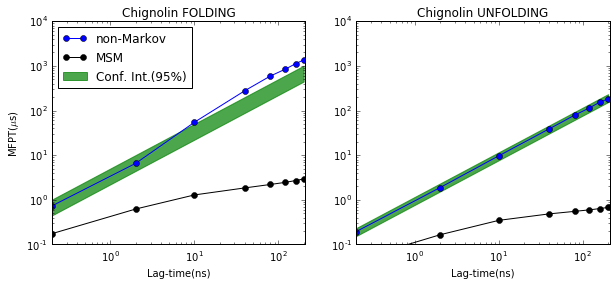

In [10]:
empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

fig =plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.7, color="green", label="Conf. Int.(95%)" )
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="non-Markov" )
ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag-time(ns)")
ax1.set_ylabel("MFPT($\mu$s)")
ax1.legend(loc='upper left')
ax1.set_xlim(0,210)
#ax1.plot(x, [empirical_mfptsAB[0] for i in x], "--", color='red')

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.7, color="green", label="Conf. Int.(95%)" )
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="non-Markov" )
ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag-time(ns)")
ax2.set_xlim(0,210)
#ax2.plot(x, [empirical_mfptsBA[0] for i in x], "--", color='red')


plt.show()

## Markov + Color : History Analysis (Lag=1tau)

In [11]:
dt =0.0002

discrete_traj = cluster.dtrajs

history = np.array([0, 1, 10, 50, 100, 200, 300, 400, 500])
mpc_mfptsAB = []
mpc_mfptsBA = []

for hist in history:
    model = MarkovPlusColorModel(discrete_traj, stateA, stateB, hist_length=hist)
    kinetics = model.mfpts()
    mpc_mfptsAB.append(kinetics['mfptAB']*dt)
    mpc_mfptsBA.append(kinetics['mfptBA']*dt)

# Empirical values:
emp_mfpts = model.empirical_mfpts()

emp_mfptAB = emp_mfpts['mfptAB']*dt
emp_mfptBA = emp_mfpts['mfptBA']*dt
emp_std_err_mfptAB = emp_mfpts['std_err_mfptAB']*dt
emp_std_err_mfptBA = emp_mfpts['std_err_mfptBA']*dt

Number of A->B/B->A  events: 116/116


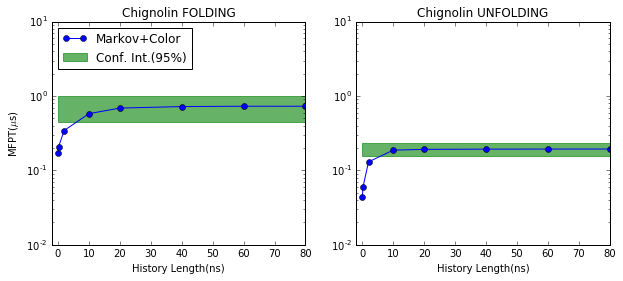

In [12]:
fig =plt.figure(figsize = (10,4))

err_maxAB = [emp_mfptAB + 2*emp_std_err_mfptAB for _ in history]
err_minAB = [emp_mfptAB - 2*emp_std_err_mfptAB for _ in history]
err_maxBA = [emp_mfptBA + 2*emp_std_err_mfptBA for _ in history]
err_minBA = [emp_mfptBA - 2*emp_std_err_mfptBA for _ in history]

ax1 = fig.add_subplot(121)
ax1.fill_between(history*0.2, err_minAB, err_maxAB,
                 alpha=0.6, color="green", label="Conf. Int.(95%)" )
ax1.plot(history*0.2, mpc_mfptsAB, "-o", label="Markov+Color" )
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("History Length(ns)")
ax1.set_ylabel("MFPT($\mu$s)")
ax1.legend(loc='upper left')
ax1.set_xlim(-2,80)
ax1.set_ylim(0.01,10)

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(history*0.2, err_minBA, err_maxBA,
                 alpha=0.6, color="green", label="Conf. Int.(95%)" )
ax2.plot(history*0.2, mpc_mfptsBA, "-o", label="Markov+Color" )
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("History Length(ns)")
#ax2.legend(loc='upper left')
ax2.set_xlim(-2,80)
ax2.set_ylim(0.01,10)


plt.show()


## Path Ensemble

In [13]:
from mfpt import directional_mfpt
from nmm import NonMarkovModel

# from ensembles import DiscretePathEnsemble

# path_ens = DiscretePathEnsemble.from_transition_matrix()

nm_model2 = NonMarkovModel(cluster.dtrajs, stateA, stateB)
nm_model2.mfpts()

{'mfptAB': 3641.1723232026361, 'mfptBA': 968.56505478275051}

In [14]:
directional_mfpt(nm_model2.tmatrixAB(), nm_model2.stateA, nm_model.stateB, ini_probs=nm_model2.fluxBA_distribution_on_A())

3641.1723232029726

In [15]:
from mfpt import fpt_distribution

fptd = fpt_distribution(nm_model2.tmatrixAB(), nm_model2.stateA,
                                nm_model2.stateB,
                                initial_distrib=nm_model2.fluxBA_distribution_on_A(), max_n_lags=10000)

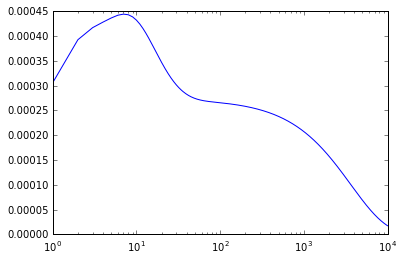

2760.74727718


In [16]:
plt.plot(fptd)
plt.xscale("log")
plt.show()

print(sum([(i+1)*x for i,x in enumerate(fptd)]))

In [17]:
fptd[0]

4.5091706161806885e-05